In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [27]:
from collections import Counter
import json

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
train_df = pd.read_csv("../data/baseline/train_base.csv")
val_df   = pd.read_csv("../data/baseline/val_base.csv")
test_df  = pd.read_csv("../data/baseline/test_base.csv")
train_df.head()


,post_id,source,text,label
0,23107796_gab,gab,u really think would not raped feral hindu mus...,offensive
1,9995600_gab,gab,uk threatened return radioactive waste eu agre...,offensive
2,1227920812235051008_twitter,twitter,english not imposition hindi also not impositi...,offensive
3,1204931715778543624_twitter,twitter,no liberal congratulated hindu refugees post c...,offensive
4,1179102559241244672_twitter,twitter,said bro even texts sound redneck whatever fuc...,offensive


In [6]:
lab_enco = LabelEncoder()

In [7]:
train_df["encoded_label"] = lab_enco.fit_transform(train_df["label"])
val_df["encoded_label"]   = lab_enco.transform(val_df["label"])
test_df["encoded_label"]  = lab_enco.transform(test_df["label"])

In [8]:
lab_enco.classes_

array(['hatespeech', 'normal', 'offensive'], dtype=object)

In [9]:
def vocab(texts,max_vocab=20000):
    cnt = Counter()
    for text in texts:
        cnt.update(text.split())
    most_common = cnt.most_common(max_vocab-2)
    vocab = {"<PAD>":0,"<UNK>":1}
    for i,(word,_) in enumerate(most_common,start=2):
        vocab[word] = i
    return vocab

In [10]:
vocab = vocab(train_df['text'],max_vocab=20000)
len(vocab)

20000

In [11]:
max_words = 100

def encode(text,vocab,max_len):
    tokens = text.split()
    ids = [vocab.get(t,vocab['<UNK>']) for t in tokens][:max_len]
    return ids + [0]*(max_len-len(ids))


In [12]:
train_df["encoded"] = train_df["text"].astype(str).apply(lambda x: encode(x, vocab, max_words))
val_df["encoded"]   = val_df["text"].astype(str).apply(lambda x: encode(x, vocab, max_words))
test_df["encoded"]  = test_df["text"].astype(str).apply(lambda x: encode(x, vocab, max_words))
train_df.sample(5)

,post_id,source,text,label,encoded_label,encoded
11512,1212465094338187265_twitter,twitter,USER lmaoo ya punk ass ghetto,offensive,2,"[2, 3372, 331, 2742, 46, 18, 0, 0, 0, 0, 0, 0,..."
5745,1179090464290611201_twitter,twitter,USER haha imagine liking tj3 environment made ...,offensive,2,"[2, 1146, 421, 2388, 16526, 3018, 139, 16527, ..."
12983,1179103691921661952_twitter,twitter,USER USER not wait twee hypocrisy oughterard p...,normal,1,"[2, 2, 3, 360, 9057, 2259, 1, 976, 10545, 2837..."
2994,3M7OI89LVYPH1HX3DNMAD4RW6BM6CJ_nf_4,twitter,oh shit nigger layoffs habbening,hatespeech,0,"[118, 21, 5, 14206, 14207, 0, 0, 0, 0, 0, 0, 0..."
9421,19452516_gab,gab,big showy anomalous attacks fema fingerprints ...,hatespeech,0,"[168, 19663, 19664, 620, 11180, 19665, 1192, 3..."


In [13]:
class TextDataset(Dataset):
    def __init__(self,df):
        self.texts = df["encoded"].tolist()
        self.labels = df["encoded_label"].tolist()
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        return (torch.tensor(self.texts[idx],dtype=torch.long),torch.tensor(self.labels[idx],dtype=torch.long))

In [14]:
train_ds = TextDataset(train_df)
val_ds   = TextDataset(val_df)
test_ds  = TextDataset(test_df)

In [15]:
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64)
test_loader  = DataLoader(test_ds, batch_size=64)

In [16]:
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dimen, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dimen, padding_idx=0)
        self.lstm = nn.LSTM(embed_dimen, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),
        )
    
    def forward(self,x):
        x = self.embedding(x)
        out,_ = self.lstm(x)
        out = out.mean(dim=1)
        return self.fc(out)

In [17]:
model = BiLSTM(vocab_size=len(vocab),embed_dimen=100,hidden_dim=128,num_classes=3).to(device)
model

BiLSTM(
  (embedding): Embedding(20000, 100, padding_idx=0)
  (lstm): LSTM(100, 128, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [19]:
def train(model, loader):
    model.train()
    total_loss = 0
    for x, y in tqdm(loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

In [20]:
def eval(model, loader):
    model.eval()
    preds, labels = [], []
    
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds.extend(out.argmax(1).cpu().numpy())
            labels.extend(y.cpu().numpy())
             
    return preds, labels


In [ ]:
train_loss = []
EPOCHS = 25
for epoch in range(EPOCHS):
    loss = train(model, train_loader)
    train_loss.append(loss)
    print(f"Epoch {epoch+1} | Loss: {loss:.4f}")

100%|██████████| 241/241 [00:02<00:00, 103.95it/s]


Epoch 1 | Loss: 1.0193


100%|██████████| 241/241 [00:02<00:00, 116.94it/s]


Epoch 2 | Loss: 0.8850


100%|██████████| 241/241 [00:02<00:00, 118.71it/s]


Epoch 3 | Loss: 0.7865


100%|██████████| 241/241 [00:02<00:00, 119.69it/s]


Epoch 4 | Loss: 0.6829


100%|██████████| 241/241 [00:02<00:00, 119.51it/s]


Epoch 5 | Loss: 0.5863


100%|██████████| 241/241 [00:02<00:00, 119.67it/s]


Epoch 6 | Loss: 0.4849


100%|██████████| 241/241 [00:02<00:00, 119.24it/s]


Epoch 7 | Loss: 0.3911


100%|██████████| 241/241 [00:02<00:00, 117.26it/s]


Epoch 8 | Loss: 0.2982


100%|██████████| 241/241 [00:02<00:00, 119.29it/s]


Epoch 9 | Loss: 0.2336


100%|██████████| 241/241 [00:02<00:00, 119.11it/s]


Epoch 10 | Loss: 0.1826


100%|██████████| 241/241 [00:02<00:00, 118.62it/s]


Epoch 11 | Loss: 0.1434


100%|██████████| 241/241 [00:02<00:00, 118.06it/s]


Epoch 12 | Loss: 0.1212


100%|██████████| 241/241 [00:02<00:00, 117.90it/s]


Epoch 13 | Loss: 0.0988


100%|██████████| 241/241 [00:02<00:00, 118.99it/s]


Epoch 14 | Loss: 0.0790


100%|██████████| 241/241 [00:02<00:00, 118.46it/s]


Epoch 15 | Loss: 0.0769


100%|██████████| 241/241 [00:02<00:00, 119.24it/s]


Epoch 16 | Loss: 0.0614


100%|██████████| 241/241 [00:02<00:00, 119.08it/s]


Epoch 17 | Loss: 0.0511


100%|██████████| 241/241 [00:02<00:00, 119.11it/s]


Epoch 18 | Loss: 0.0401


100%|██████████| 241/241 [00:02<00:00, 119.83it/s]


Epoch 19 | Loss: 0.0339


100%|██████████| 241/241 [00:02<00:00, 118.51it/s]


Epoch 20 | Loss: 0.0497


100%|██████████| 241/241 [00:02<00:00, 114.09it/s]


Epoch 21 | Loss: 0.0295


100%|██████████| 241/241 [00:02<00:00, 116.06it/s]


Epoch 22 | Loss: 0.0204


100%|██████████| 241/241 [00:02<00:00, 117.70it/s]


Epoch 23 | Loss: 0.0153


100%|██████████| 241/241 [00:02<00:00, 116.36it/s]


Epoch 24 | Loss: 0.0136


100%|██████████| 241/241 [00:02<00:00, 115.86it/s]

Epoch 25 | Loss: 0.0283


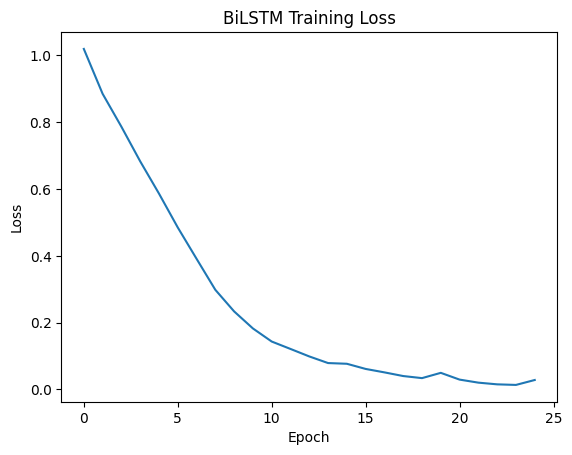

In [24]:
plt.plot(train_loss)
plt.title("BiLSTM Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("../figures/bilstm_training_loss.png",dpi=300,bbox_inches="tight" )
plt.show()


In [28]:
y_pred,y_true = eval(model,test_loader)

class_repo = classification_report(y_true,y_pred,target_names=lab_enco.classes_,digits=4,output_dict=True)
print(class_repo)

{'hatespeech': {'precision': 0.6845753899480069, 'recall': 0.664983164983165, 'f1-score': 0.6746370623398804, 'support': 594.0}, 'normal': {'precision': 0.6292834890965732, 'recall': 0.7749360613810742, 'f1-score': 0.6945558739255014, 'support': 782.0}, 'offensive': {'precision': 0.4635416666666667, 'recall': 0.3248175182481752, 'f1-score': 0.38197424892703863, 'support': 548.0}, 'accuracy': 0.6127858627858628, 'macro avg': {'precision': 0.5924668485704155, 'recall': 0.5882455815374714, 'f1-score': 0.5837223950641401, 'support': 1924.0}, 'weighted avg': {'precision': 0.5991467273575726, 'recall': 0.6127858627858628, 'f1-score': 0.5993757779894221, 'support': 1924.0}}


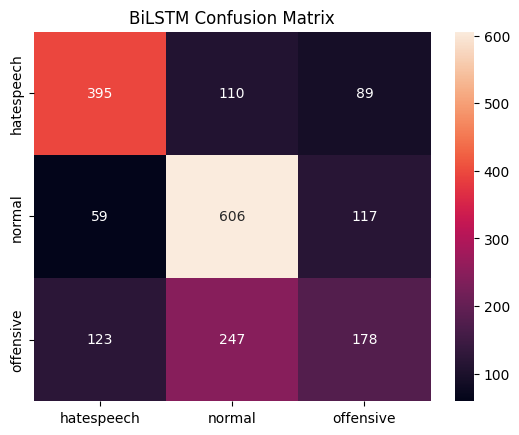

In [26]:
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=lab_enco.classes_,
            yticklabels=lab_enco.classes_)
plt.title("BiLSTM Confusion Matrix")
plt.savefig("../figures/bilstm_conf_heatmap.png",dpi=300,bbox_inches="tight" )
plt.show()


In [29]:
with open("../results/bilstm/metrics.json", "w") as f:
    json.dump(class_repo, f, indent=4)

In [30]:
pd.DataFrame(cm, index=lab_enco.classes_, columns=lab_enco.classes_).to_csv("../results/bilstm/confusion_matrix.csv")

In [31]:
pred_df = test_df.copy()
pred_df["predicted_label"] = lab_enco.inverse_transform(y_pred)
pred_df.to_csv("../results/bilstm/predictions.csv", index=False)

In [32]:
torch.save(model.state_dict(), "../models/bilstm/bilstm_model.pt")